In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import os
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

data_dir = '/content/drive/MyDrive/dog_cat'

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, subfolder in enumerate(['Cat', 'Dog']):
            folder_path = Path(image_dir) / subfolder
            for img_file in Path(folder_path).rglob('*.*'):
                self.image_paths.append(img_file)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
image_size = 224
data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = CustomImageDataset(image_dir=data_dir, transform=data_transforms)
batch_size = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("DataLoader created successfully with", len(dataset), "images.")


DataLoader created successfully with 1000 images.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Initialize the Swin Transformer model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=2)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [7]:
print(f'Using device: {device}')

Using device: cuda


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(dataset)
        epoch_acc = corrects.double() / len(dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [10]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

model_save_path = 'swin_transformer_cat_dog_best.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Epoch 1/10
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.1022 Acc: 0.9710

Epoch 2/10
------------------------------
Loss: 0.0297 Acc: 0.9920

Epoch 3/10
------------------------------
Loss: 0.0165 Acc: 0.9930

Epoch 4/10
------------------------------
Loss: 0.0062 Acc: 0.9990

Epoch 5/10
------------------------------
Loss: 0.0157 Acc: 0.9950

Epoch 6/10
------------------------------
Loss: 0.0002 Acc: 1.0000

Epoch 7/10
------------------------------
Loss: 0.0004 Acc: 1.0000

Epoch 8/10
------------------------------
Loss: 0.0001 Acc: 1.0000

Epoch 9/10
------------------------------
Loss: 0.0001 Acc: 1.0000

Epoch 10/10
------------------------------
Loss: 0.0001 Acc: 1.0000

Training complete in 7m 12s
Best Acc: 1.0000
Model saved to swin_transformer_cat_dog_best.pth


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


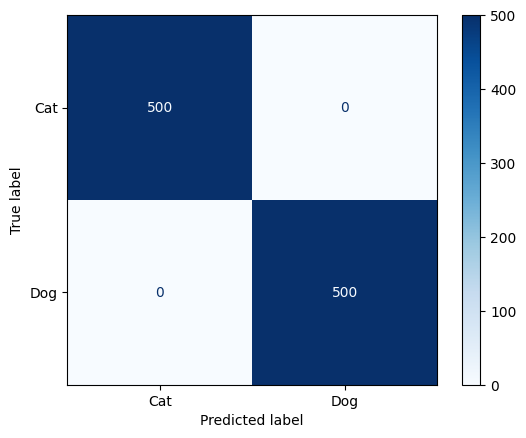

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

evaluate_model(model, data_loader)


In [13]:
from sklearn.metrics import classification_report

def classification_report_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=['Cat', 'Dog'])
    print(report)

classification_report_metrics(model, data_loader)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

         Cat       1.00      1.00      1.00       500
         Dog       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



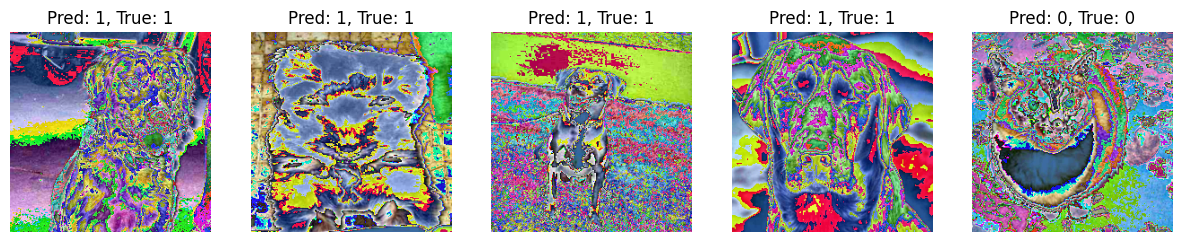

In [15]:
import matplotlib.pyplot as plt

def show_sample_predictions(model, data_loader, num_samples=5):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move tensors to CPU
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    # Plot sample images with predictions
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(transforms.ToPILImage()(images[i]))
        ax.set_title(f'Pred: {preds[i].item()}, True: {labels[i].item()}')
        ax.axis('off')
    plt.show()

show_sample_predictions(model, data_loader)
